# KSB Sample Exploration

### Random Forest predictions vs Symbolic Classifier predictions

In [1]:
import joblib
import numpy as np
import pandas as pd
from gplearn.genetic import SymbolicClassifier

import sympy as sym
from sympy import Symbol, sympify, lambdify, abc, SympifyError, simplify

from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from pandas_profiling import ProfileReport
from tqdm import tqdm_notebook as tqdm

In [2]:
cmap_rg = colors.ListedColormap(['firebrick', 'green'])

In [3]:
# Protected division - if the denominator lies between -0.001 and 0.001, returns 1.0
def protected_div(x, y):
    try:
        if -0.001 <= y <= 0.001:
            return 1.0
    except TypeError:
        return x/y
    else:
        return x/y

# Protected square root - returns the square root of the absolute value of the argument
def protected_sqrt(x):
    return sym.sqrt(sym.Abs(x))

# Protected log - returns the logarithm of the absolute value of the argument, or for very small values less than 0.001, it returns 0.0
def protected_log(x):
    try:
        if -0.001 <= x <= 0.001:
            return 0.0
    except TypeError:
        return sym.log(sym.Abs(x))
    else:
        return sym.log(sym.Abs(x))


In [4]:
converter = {
        'add': lambda x, y : x + y,
        'sub': lambda x, y : x - y,
        'mul': lambda x, y : x*y,
        'div': lambda x, y : protected_div(x,y),
        'sqrt': lambda x : protected_sqrt(x),
        'log': lambda x : protected_log(x),
        'abs': lambda x : sym.Abs(x),
        'neg': lambda x : -x,
        'max': lambda x, y : sym.Max(x, y),
        'min': lambda x, y : sym.Min(x, y),
        'sin': lambda x : sym.sin(x),
        'cos': lambda x : sym.cos(x),
        'tan': lambda x : sym.tan(x),
        #'inv': lambda x :,
    }

In [5]:
def calculate_function_values_from_sympy(function, data_points, variable_names=None):
    
    if variable_names is None:
        variable_names = ['X' + str(i) for i in range(data_points.shape[1])]
    
    if function is None:
        return np.array([np.nan for i in range(data_points.shape[0])])
    try:
        if variable_names == None:
            function_vars = function.atoms(Symbol)
        else:
            function_vars = [sym.symbols(variable_name) for variable_name in variable_names]
        #print('function_vars', function_vars)
        lambda_function = lambdify([function_vars], function, modules=["scipy", "numpy"])
        #print('lambda_function', lambda_function)
        #print('data_points[0]', data_points[0])
        if len(function_vars) >= 1:
            function_values = [lambda_function(data_point) for data_point in data_points]
            
        else:
            function_values = [lambda_function() for i in range(data_points.shape[0])]
    except (NameError, KeyError) as e:
        #print(e)
        function_values = []
        for data_point in data_points:
            function_value = function.evalf(subs={var: data_point[index] for index, var in enumerate(list(function_vars))})
            try:
                function_value = float(function_value)
            except TypeError as te:
                #print(te)
                #print(function_value)
                function_value = np.inf
            function_values.append(function_value)
    function_values = np.nan_to_num(function_values).ravel()
                
    return function_values

# Load Data

In [6]:
with open('./data/dataset_2_pumps.pkl', 'rb') as fp:
    data = joblib.load(fp)

In [7]:
data

,pumpid,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead,onoff_proba
0,7bacb644-d600-4aa3-909f-c03c2077ff70,-2.123735,-1.062500,0.343480,94.45,0.047541
1,7bacb644-d600-4aa3-909f-c03c2077ff70,-3.886206,-0.683515,-1.910343,94.45,0.000119
2,7bacb644-d600-4aa3-909f-c03c2077ff70,-4.019799,-0.540290,-2.004817,94.45,0.000119
3,7bacb644-d600-4aa3-909f-c03c2077ff70,-3.876123,-0.483659,-1.905951,94.45,0.000119
4,7bacb644-d600-4aa3-909f-c03c2077ff70,2.666156,-0.375000,0.476810,94.45,0.265332
...,...,...,...,...,...,...
24811,6826ff5e-f760-4e57-9f42-14797b8319ef,2.475133,3.444166,0.940906,23.00,0.997134
24812,6826ff5e-f760-4e57-9f42-14797b8319ef,2.488424,3.442503,0.958015,23.00,0.997134
24813,6826ff5e-f760-4e57-9f42-14797b8319ef,2.491038,3.520001,0.938072,23.00,0.997134
24814,6826ff5e-f760-4e57-9f42-14797b8319ef,2.454421,3.572500,0.904463,23.00,0.995626


In [8]:
profile = ProfileReport(data)
profile

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
ksb_sample = data.copy()
ksb_sample['pumpid'].value_counts()

7bacb644-d600-4aa3-909f-c03c2077ff70    23422
6826ff5e-f760-4e57-9f42-14797b8319ef    23291
Name: pumpid, dtype: int64

In [10]:
ksb_sample['state'] = np.where(ksb_sample['onoff_proba'] >= 0.5, 1, 0)

In [13]:
X = ksb_sample.drop(['state', 'pumpid'], axis=1)
X.head()

# Test Symbolic Classification Results

In [21]:
#Best
print('\n"Best"')
sym_cla_pred = np.where(calculate_function_values_from_sympy(simplify(sympify('add(min(div(abs(div(X1, X3)), div(X1, X3)), add(X0, X0)), add(X0, log(max(div(abs(div(X1, sub(log(div(div(X1, sub(log(div(X1, X3)), div(X3, add(-0.860, -0.530)))), X3)), div(max(X3, X2), add(-0.860, -0.530))))), abs(0.052)), abs(0.052)))))', locals=converter)), X.values) > 0, 1, 0).astype(np.int64).reshape(-1,1)
print('F1 Score - Fidelity Symbolic preds vs RF preds:', f1_score(sym_cla_pred, ksb_sample['state']))
print('Accuracy - Fidelity Symbolic preds vs RF preds::', accuracy_score(sym_cla_pred, ksb_sample['state']))

#Best Reduced
print('\n"Best Reduced"')
sym_cla_pred = np.where(calculate_function_values_from_sympy(simplify(sympify('sub(add(min(max(X2, X1), add(min(max(X2, add(0.867, X2)), add(0.867, X0)), X2)), mul(div(X0, X2), add(X2, X2))), max(sub(max(sub(0.423, 0.606), X2), div(X1, X1)), add(0.606, sub(add(add(0.867, X2), X0), max(max(div(0.487, X3), add(X1, -0.710)), add(X1, -0.710))))))', locals=converter)), X.values) > 0, 1, 0).astype(np.int64).reshape(-1,1)
print('F1 Score - Fidelity Symbolic preds vs RF preds:', f1_score(sym_cla_pred, ksb_sample['state']))
print('Accuracy - Fidelity Symbolic preds vs RF preds::', accuracy_score(sym_cla_pred, ksb_sample['state']))

#Min Max
print('\n"Min Max"')
sym_cla_pred = np.where(calculate_function_values_from_sympy(simplify(sympify('sub(X0, neg(min(sub(sub(X0, neg(min(sub(X0, -0.774), max(X1, -0.870)))), -0.774), max(X1, -0.870))))', locals=converter)), X.values) > 0, 1, 0).astype(np.int64).reshape(-1,1)
print('F1 Score - Fidelity Symbolic preds vs RF preds:', f1_score(sym_cla_pred, ksb_sample['state']))
print('Accuracy - Fidelity Symbolic preds vs RF preds::', accuracy_score(sym_cla_pred, ksb_sample['state']))

#Simple
print('\n"Simple"')
sym_cla_pred = np.where(calculate_function_values_from_sympy(simplify(sympify('add(X0, X0)', locals=converter)), X.values) > 0, 1, 0).astype(np.int64).reshape(-1,1)
print('F1 Score - Fidelity Symbolic preds vs RF preds:', f1_score(sym_cla_pred, ksb_sample['state']))
print('Accuracy - Fidelity Symbolic preds vs RF preds::', accuracy_score(sym_cla_pred, ksb_sample['state']))


"Best"


<lambdifygenerated-4>:3: RuntimeWarning: invalid value encountered in double_scalars
  return (X0 + log(amax((0.052,19.2307692307692*abs(X1/(log(abs(X1/(X3*(0.719424460431655*X3 + log(abs(X1/X3)))))) + 0.719424460431655*amax((X2,X3), axis=0)))), axis=0)) + amin((2*X0,X3*abs(X1/X3)/X1), axis=0))


F1 Score - Fidelity Symbolic preds vs RF preds: 0.885362598250037
Accuracy - Fidelity Symbolic preds vs RF preds:: 0.8014257273135957

"Best Reduced"
F1 Score - Fidelity Symbolic preds vs RF preds: 0.7893556546454927
Accuracy - Fidelity Symbolic preds vs RF preds:: 0.6541433862094064

"Min Max"
F1 Score - Fidelity Symbolic preds vs RF preds: 0.8641295705041164
Accuracy - Fidelity Symbolic preds vs RF preds:: 0.7622289298482221

"Simple"
F1 Score - Fidelity Symbolic preds vs RF preds: 0.8856539375465041
Accuracy - Fidelity Symbolic preds vs RF preds:: 0.7960310834243144


# Exploration Energy

## All data - Both pumps

<AxesSubplot:xlabel='index', ylabel='energy_norm_log'>

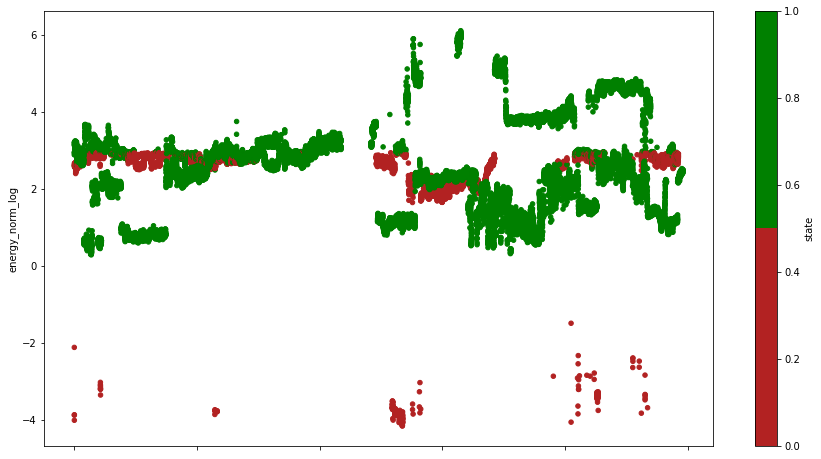

In [22]:
ksb_sample.reset_index().plot.scatter(x='index', y='energy_norm_log',c='state',colormap=cmap_rg, figsize=(15, 8))

<AxesSubplot:xlabel='index', ylabel='energy_norm_log'>

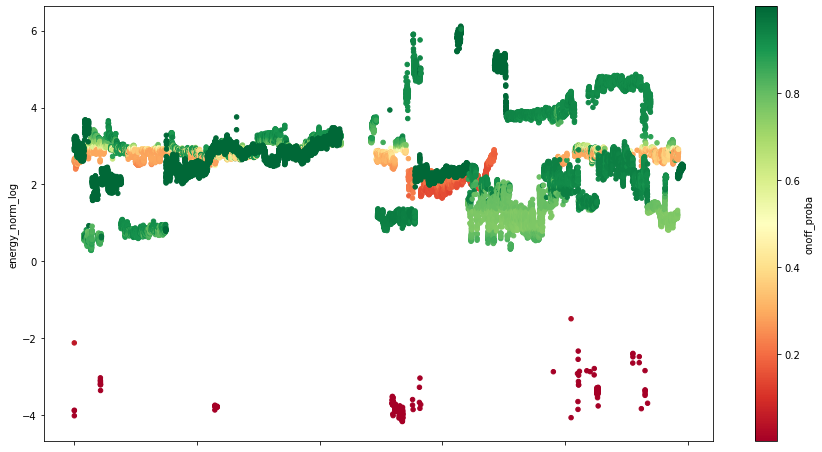

In [23]:
ksb_sample.reset_index().plot.scatter(x='index', y='energy_norm_log',c='onoff_proba',colormap='RdYlGn', figsize=(15, 8))

### Data sorted by energy

<AxesSubplot:xlabel='index', ylabel='energy_norm_log'>

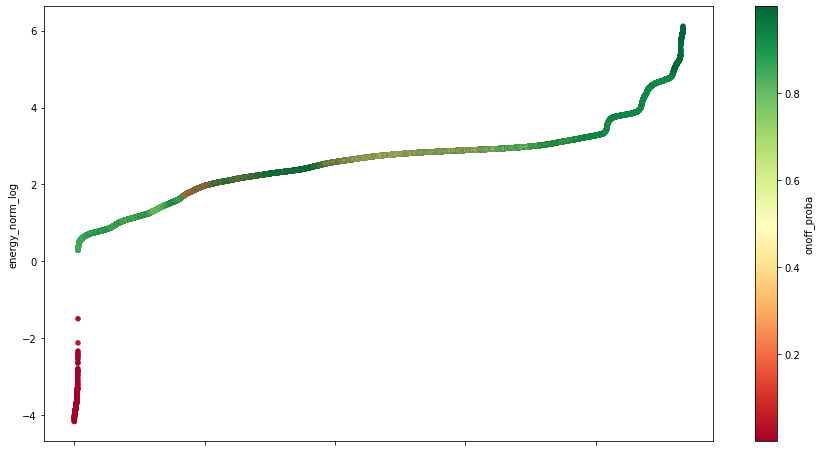

In [24]:
ksb_sample_sorted = ksb_sample.sort_values(by=['energy_norm_log'])
ksb_sample_sorted.reset_index()[['energy_norm_log','onoff_proba','state']].reset_index().plot.scatter(x='index', y='energy_norm_log',c='onoff_proba',colormap='RdYlGn', figsize=(15, 8))

## Split data into single pumps

In [25]:
pump_a = ksb_sample[ksb_sample['pumpid'] == '7bacb644-d600-4aa3-909f-c03c2077ff70']
pump_b = ksb_sample[ksb_sample['pumpid'] == '6826ff5e-f760-4e57-9f42-14797b8319ef']

## Test Symbolic Classification Results - Separate Pumps

## Pump A

#### Plot of Random Forest Classification compared to energy_norm_log variable

<AxesSubplot:xlabel='index', ylabel='energy_norm_log'>

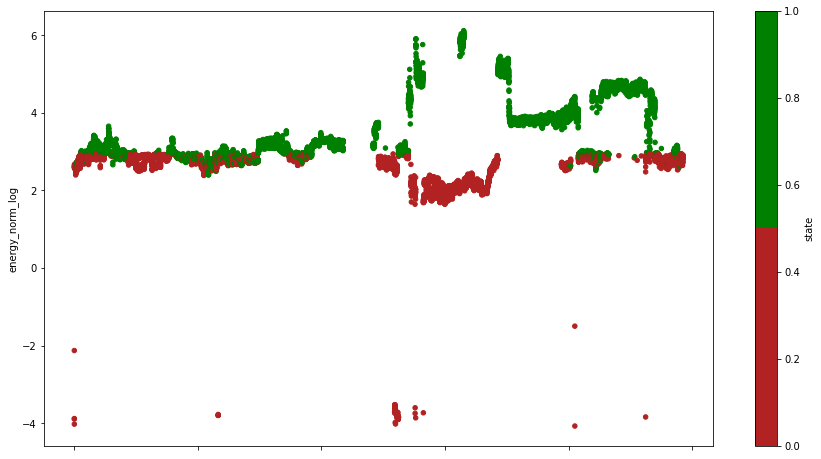

In [26]:
pump_a.reset_index().plot.scatter(x='index', y='energy_norm_log',c='state',colormap=cmap_rg, figsize=(15, 8))

<AxesSubplot:xlabel='index', ylabel='energy_norm_log'>

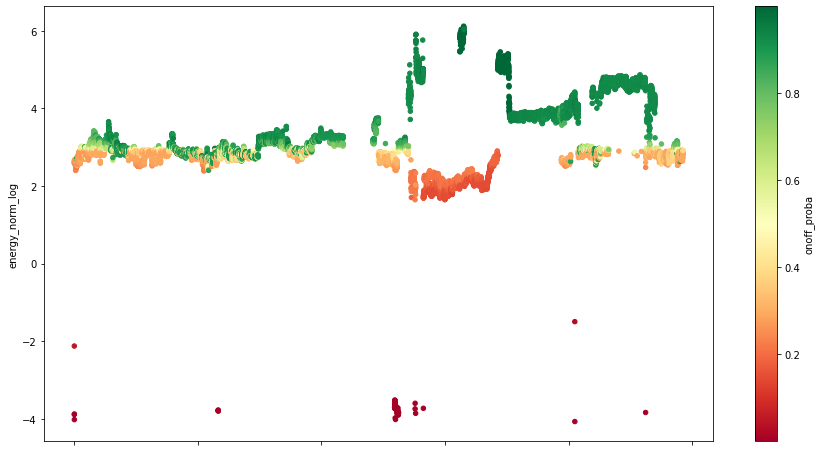

In [27]:
pump_a.reset_index().plot.scatter(x='index', y='energy_norm_log',c='onoff_proba',colormap='RdYlGn', figsize=(15, 8))

<AxesSubplot:xlabel='index', ylabel='energy_norm_log'>

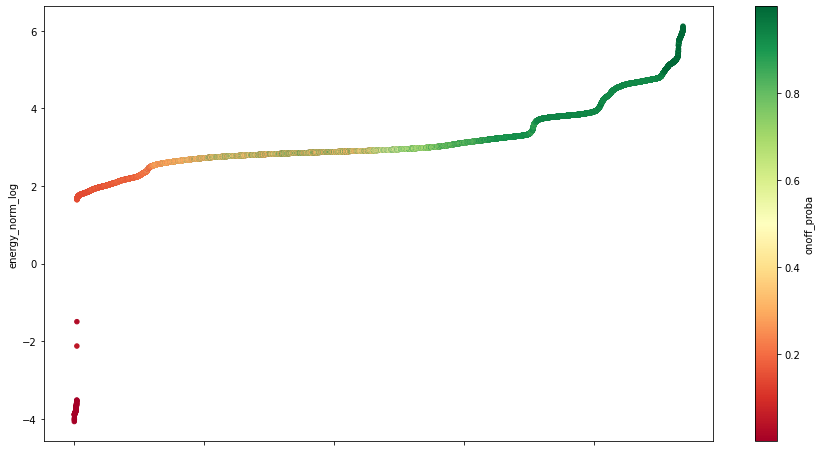

In [28]:
pump_a_sorted = pump_a.sort_values(by=['energy_norm_log'])
pump_a_sorted.reset_index()[['energy_norm_log','onoff_proba','state']].reset_index().plot.scatter(x='index', y='energy_norm_log',c='onoff_proba',colormap='RdYlGn', figsize=(15, 8))

In [29]:
#Best
print('\n"Best"')
sym_cla_pred = np.where(calculate_function_values_from_sympy(simplify(sympify('add(min(div(abs(div(X1, X3)), div(X1, X3)), add(X0, X0)), add(X0, log(max(div(abs(div(X1, sub(log(div(div(X1, sub(log(div(X1, X3)), div(X3, add(-0.860, -0.530)))), X3)), div(max(X3, X2), add(-0.860, -0.530))))), abs(0.052)), abs(0.052)))))', locals=converter)), pump_a.drop(['pumpid','onoff_proba','state'], axis=1).values) > 0, 1, 0).astype(np.int64).reshape(-1,1)
print('Pump A: F1 Score - Fidelity Symbolic preds vs RF preds:', f1_score(sym_cla_pred, pump_a['state']))
print('Pump A: Accuracy - Fidelity Symbolic preds vs RF preds:', accuracy_score(sym_cla_pred, pump_a['state']))

#Best Reduced
print('\n"Best Reduced"')
sym_cla_pred = np.where(calculate_function_values_from_sympy(simplify(sympify('sub(add(min(max(X2, X1), add(min(max(X2, add(0.867, X2)), add(0.867, X0)), X2)), mul(div(X0, X2), add(X2, X2))), max(sub(max(sub(0.423, 0.606), X2), div(X1, X1)), add(0.606, sub(add(add(0.867, X2), X0), max(max(div(0.487, X3), add(X1, -0.710)), add(X1, -0.710))))))', locals=converter)), pump_a.drop(['pumpid','onoff_proba','state'], axis=1).values) > 0, 1, 0).astype(np.int64).reshape(-1,1)
print('Pump A: F1 Score - Fidelity Symbolic preds vs RF preds:', f1_score(sym_cla_pred, pump_a['state']))
print('Pump A: Accuracy - Fidelity Symbolic preds vs RF preds:', accuracy_score(sym_cla_pred, pump_a['state']))

#Min Max
print('\n"Min Max"')
sym_cla_pred = np.where(calculate_function_values_from_sympy(simplify(sympify('sub(X0, neg(min(sub(sub(X0, neg(min(sub(X0, -0.774), max(X1, -0.870)))), -0.774), max(X1, -0.870))))', locals=converter)), pump_a.drop(['pumpid','onoff_proba','state'], axis=1).values) > 0, 1, 0).astype(np.int64).reshape(-1,1)
print('Pump A: F1 Score - Fidelity Symbolic preds vs RF preds:', f1_score(sym_cla_pred, pump_a['state']))
print('Pump A: Accuracy - Fidelity Symbolic preds vs RF preds:', accuracy_score(sym_cla_pred, pump_a['state']))

#Simple
print('\n"Simple"')
sym_cla_pred = np.where(calculate_function_values_from_sympy(simplify(sympify('add(X0, X0)', locals=converter)), pump_a.drop(['pumpid','onoff_proba','state'], axis=1).values) > 0, 1, 0).astype(np.int64).reshape(-1,1)
print('Pump A: F1 Score - Fidelity Symbolic preds vs RF preds:', f1_score(sym_cla_pred, pump_a['state']))
print('Pump A: Accuracy - Fidelity Symbolic preds vs RF preds:', accuracy_score(sym_cla_pred, pump_a['state']))


"Best"


/home/smarton/anaconda3/envs/XAI/lib/python3.8/site-packages/numpy/lib/scimath.py:272: RuntimeWarning: divide by zero encountered in log
  return nx.log(x)
<lambdifygenerated-8>:3: RuntimeWarning: invalid value encountered in double_scalars
  return (X0 + log(amax((0.052,19.2307692307692*abs(X1/(log(abs(X1/(X3*(0.719424460431655*X3 + log(abs(X1/X3)))))) + 0.719424460431655*amax((X2,X3), axis=0)))), axis=0)) + amin((2*X0,X3*abs(X1/X3)/X1), axis=0))


Pump A: F1 Score - Fidelity Symbolic preds vs RF preds: 0.763842824217213
Pump A: Accuracy - Fidelity Symbolic preds vs RF preds: 0.641277431474682

"Best Reduced"
Pump A: F1 Score - Fidelity Symbolic preds vs RF preds: 0.7432774694185483
Pump A: Accuracy - Fidelity Symbolic preds vs RF preds: 0.5932029715651951

"Min Max"
Pump A: F1 Score - Fidelity Symbolic preds vs RF preds: 0.7432774694185483
Pump A: Accuracy - Fidelity Symbolic preds vs RF preds: 0.5932029715651951

"Simple"
Pump A: F1 Score - Fidelity Symbolic preds vs RF preds: 0.7432774694185483
Pump A: Accuracy - Fidelity Symbolic preds vs RF preds: 0.5932029715651951


#### Plot of Symbolic Classifier (2*X0) predictions compared to energy_norm_log variable

In [30]:
sym_cla_pred_probs_pump_a_simple = calculate_function_values_from_sympy(simplify(sympify('add(X0, X0)', locals=converter)), pump_a.drop(['pumpid','onoff_proba','state'], axis=1).values)
sym_cla_pred_pump_a_simple = np.where(sym_cla_pred_probs_pump_a_simple > 0, 1, 0).astype(np.int64).reshape(-1,1)

pump_a_preds = pump_a.copy()
pump_a_preds['onoff_proba'] = sym_cla_pred_probs_pump_a_simple
pump_a_preds['state'] = sym_cla_pred_pump_a_simple

<AxesSubplot:xlabel='index', ylabel='energy_norm_log'>

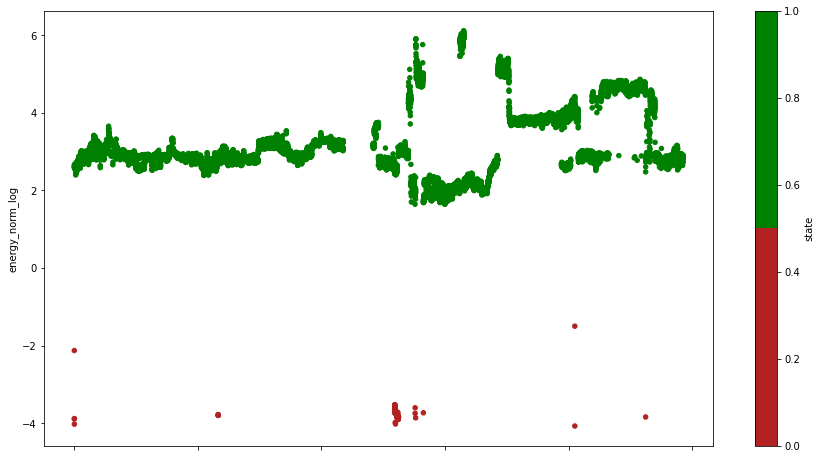

In [31]:
pump_a_preds.reset_index().plot.scatter(x='index', y='energy_norm_log',c='state',colormap=cmap_rg, figsize=(15, 8))

<AxesSubplot:xlabel='index', ylabel='energy_norm_log'>

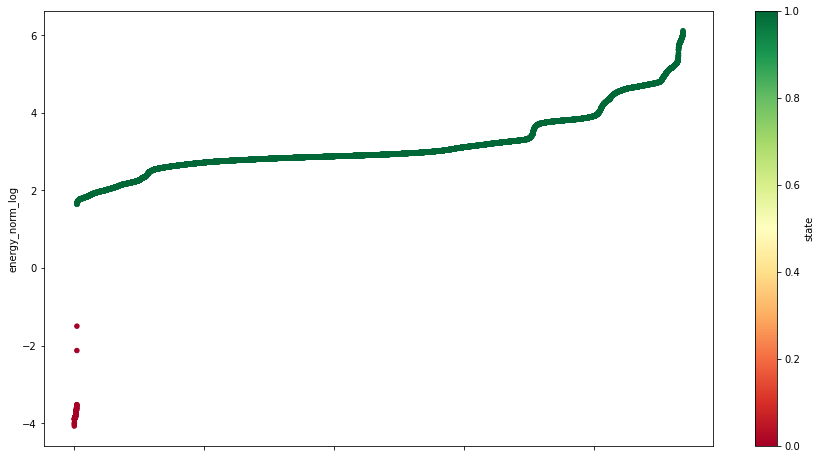

In [32]:
pump_a_preds_sorted = pump_a_preds.sort_values(by=['energy_norm_log'])
pump_a_preds_sorted.reset_index()[['energy_norm_log','onoff_proba','state']].reset_index().plot.scatter(x='index', y='energy_norm_log',c='state',colormap='RdYlGn', figsize=(15, 8))

## Pump B

#### Plots of Random Forest Classification compared to energy_norm_log variable

<AxesSubplot:xlabel='index', ylabel='energy_norm_log'>

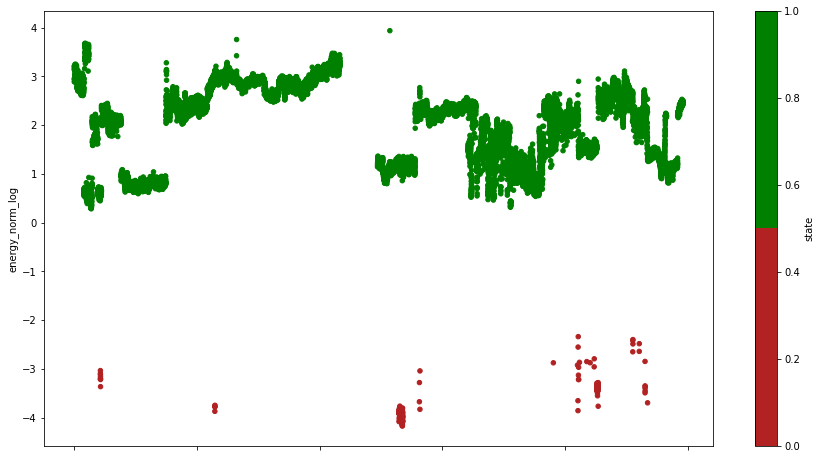

In [33]:
pump_b.reset_index().plot.scatter(x='index', y='energy_norm_log',c='state',colormap=cmap_rg, figsize=(15, 8))

<AxesSubplot:xlabel='index', ylabel='energy_norm_log'>

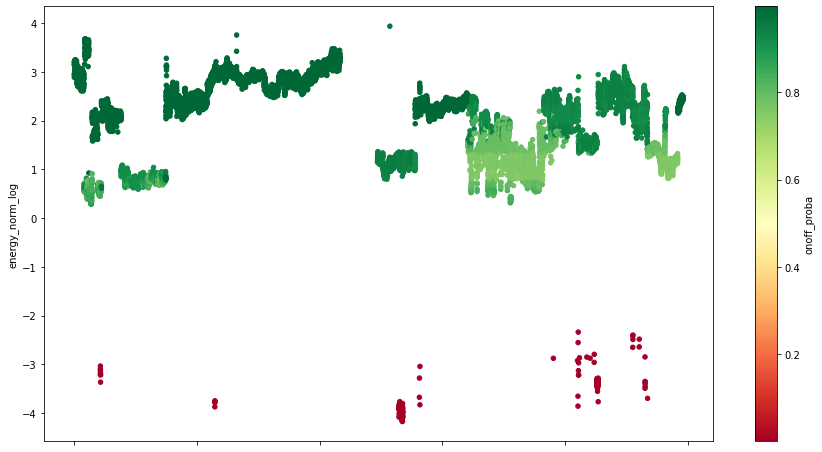

In [34]:
pump_b.reset_index().plot.scatter(x='index', y='energy_norm_log',c='onoff_proba',colormap='RdYlGn', figsize=(15, 8))

<AxesSubplot:xlabel='index', ylabel='energy_norm_log'>

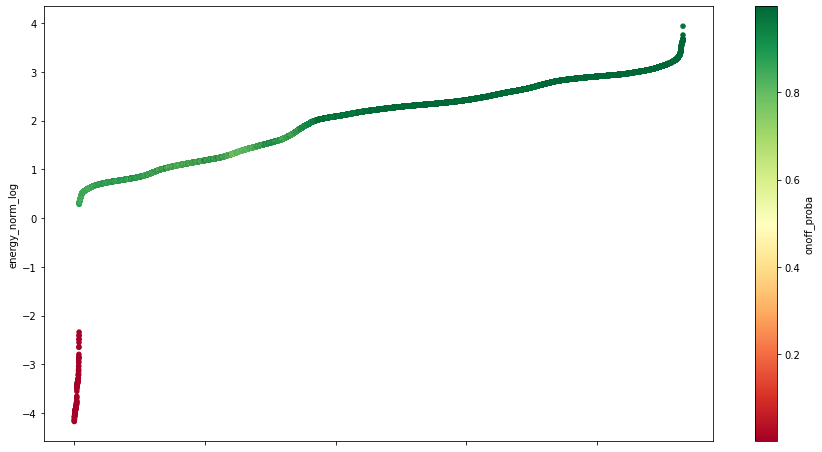

In [35]:
pump_b_sorted = pump_b.sort_values(by=['energy_norm_log'])
pump_b_sorted.reset_index()[['energy_norm_log','onoff_proba','state']].reset_index().plot.scatter(x='index', y='energy_norm_log',c='onoff_proba',colormap='RdYlGn', figsize=(15, 8))

In [36]:
#Best
print('\n"Best"')
sym_cla_pred = np.where(calculate_function_values_from_sympy(simplify(sympify('add(min(div(abs(div(X1, X3)), div(X1, X3)), add(X0, X0)), add(X0, log(max(div(abs(div(X1, sub(log(div(div(X1, sub(log(div(X1, X3)), div(X3, add(-0.860, -0.530)))), X3)), div(max(X3, X2), add(-0.860, -0.530))))), abs(0.052)), abs(0.052)))))', locals=converter)), pump_b.drop(['pumpid','onoff_proba','state'], axis=1).values) > 0, 1, 0).astype(np.int64).reshape(-1,1)
print('Pump B: F1 Score - Fidelity Symbolic preds vs RF preds:', f1_score(sym_cla_pred, pump_b['state']))
print('Pump B: Accuracy - Fidelity Symbolic preds vs RF preds:', accuracy_score(sym_cla_pred, pump_b['state']))

#Best Reduced
print('\n"Best Reduced"')
sym_cla_pred = np.where(calculate_function_values_from_sympy(simplify(sympify('sub(add(min(max(X2, X1), add(min(max(X2, add(0.867, X2)), add(0.867, X0)), X2)), mul(div(X0, X2), add(X2, X2))), max(sub(max(sub(0.423, 0.606), X2), div(X1, X1)), add(0.606, sub(add(add(0.867, X2), X0), max(max(div(0.487, X3), add(X1, -0.710)), add(X1, -0.710))))))', locals=converter)), pump_b.drop(['pumpid','onoff_proba','state'], axis=1).values) > 0, 1, 0).astype(np.int64).reshape(-1,1)
print('Pump B: F1 Score - Fidelity Symbolic preds vs RF preds:', f1_score(sym_cla_pred, pump_b['state']))
print('Pump B: Accuracy - Fidelity Symbolic preds vs RF preds:', accuracy_score(sym_cla_pred, pump_b['state']))

#Min Max
print('\n"Min Max"')
sym_cla_pred = np.where(calculate_function_values_from_sympy(simplify(sympify('sub(X0, neg(min(sub(sub(X0, neg(min(sub(X0, -0.774), max(X1, -0.870)))), -0.774), max(X1, -0.870))))', locals=converter)), pump_b.drop(['pumpid','onoff_proba','state'], axis=1).values) > 0, 1, 0).astype(np.int64).reshape(-1,1)
print('Pump B: F1 Score - Fidelity Symbolic preds vs RF preds:', f1_score(sym_cla_pred, pump_b['state']))
print('Pump B: Accuracy - Fidelity Symbolic preds vs RF preds:', accuracy_score(sym_cla_pred, pump_b['state']))

#Simple
print('\n"Simple"')
sym_cla_pred = np.where(calculate_function_values_from_sympy(simplify(sympify('add(X0, X0)', locals=converter)), pump_b.drop(['pumpid','onoff_proba','state'], axis=1).values) > 0, 1, 0).astype(np.int64).reshape(-1,1)
print('Pump B: F1 Score - Fidelity Symbolic preds vs RF preds:', f1_score(sym_cla_pred, pump_b['state']))
print('Pump B: Accuracy - Fidelity Symbolic preds vs RF preds:', accuracy_score(sym_cla_pred, pump_b['state']))


"Best"


/home/smarton/anaconda3/envs/XAI/lib/python3.8/site-packages/numpy/lib/scimath.py:272: RuntimeWarning: divide by zero encountered in log
  return nx.log(x)
<lambdifygenerated-13>:3: RuntimeWarning: invalid value encountered in double_scalars
  return (X0 + log(amax((0.052,19.2307692307692*abs(X1/(log(abs(X1/(X3*(0.719424460431655*X3 + log(abs(X1/X3)))))) + 0.719424460431655*amax((X2,X3), axis=0)))), axis=0)) + amin((2*X0,X3*abs(X1/X3)/X1), axis=0))


Pump B: F1 Score - Fidelity Symbolic preds vs RF preds: 0.9807225726763421
Pump B: Accuracy - Fidelity Symbolic preds vs RF preds: 0.9624747756644197

"Best Reduced"
Pump B: F1 Score - Fidelity Symbolic preds vs RF preds: 0.8325586095392078
Pump B: Accuracy - Fidelity Symbolic preds vs RF preds: 0.715426559615302

"Min Max"
Pump B: F1 Score - Fidelity Symbolic preds vs RF preds: 0.9646225886675779
Pump B: Accuracy - Fidelity Symbolic preds vs RF preds: 0.9322055729680992

"Simple"
Pump B: F1 Score - Fidelity Symbolic preds vs RF preds: 1.0
Pump B: Accuracy - Fidelity Symbolic preds vs RF preds: 1.0


#### Plot of Symbolic Classifier (2*X0) predictions compared to energy_norm_log variable

In [37]:
sym_cla_pred_probs_pump_b_simple = calculate_function_values_from_sympy(simplify(sympify('add(X0, X0)', locals=converter)), pump_b.drop(['pumpid','onoff_proba','state'], axis=1).values)
sym_cla_pred_pump_b_simple = np.where(sym_cla_pred_probs_pump_b_simple > 0, 1, 0).astype(np.int64).reshape(-1,1)

pump_b_preds = pump_b.copy()
pump_b_preds['onoff_proba'] = sym_cla_pred_probs_pump_b_simple
pump_b_preds['state'] = sym_cla_pred_pump_b_simple

<AxesSubplot:xlabel='index', ylabel='energy_norm_log'>

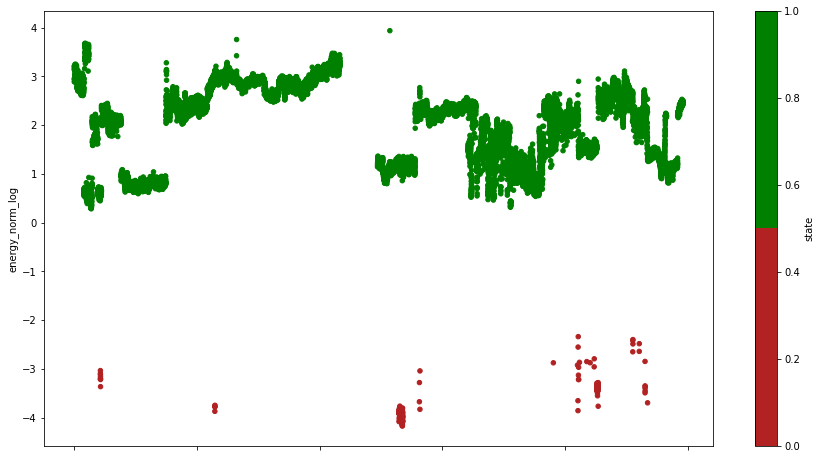

In [38]:
pump_b_preds.reset_index().plot.scatter(x='index', y='energy_norm_log',c='state',colormap=cmap_rg, figsize=(15, 8))

<AxesSubplot:xlabel='index', ylabel='energy_norm_log'>

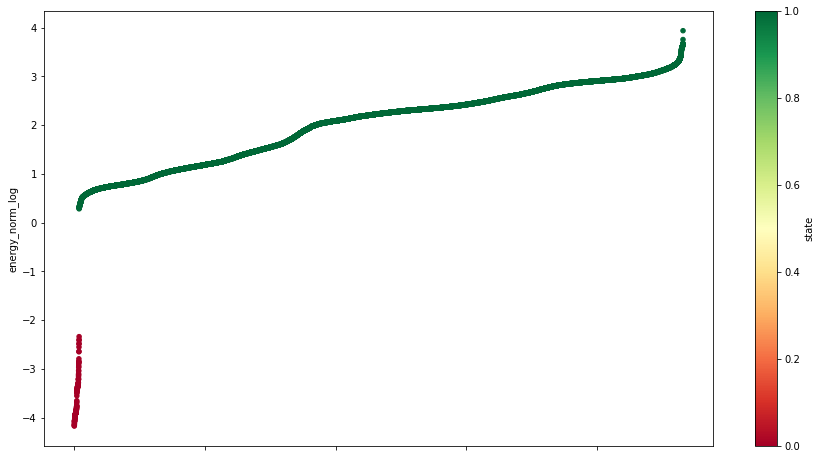

In [39]:
pump_b_preds_sorted = pump_b_preds.sort_values(by=['energy_norm_log'])
pump_b_preds_sorted.reset_index()[['energy_norm_log','onoff_proba','state']].reset_index().plot.scatter(x='index', y='energy_norm_log',c='state',colormap='RdYlGn', figsize=(15, 8))

# Extra Exploration 

In [42]:
path = "./data/replica_pump_data.csv"
pump_data_replica = pd.read_csv(path)
print(pump_data_replica.shape)

(26381042, 5)


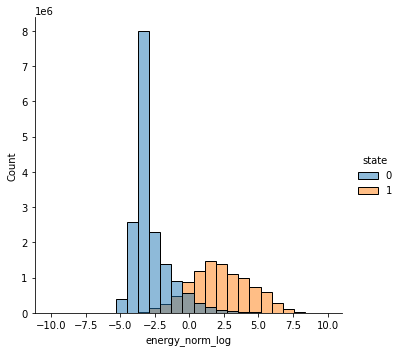

In [43]:
sns.displot(pump_data_replica, x="energy_norm_log", hue="state", bins=25)

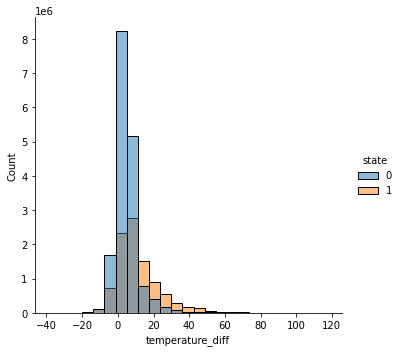

In [44]:
sns.displot(pump_data_replica, x="temperature_diff", hue="state", bins=25)

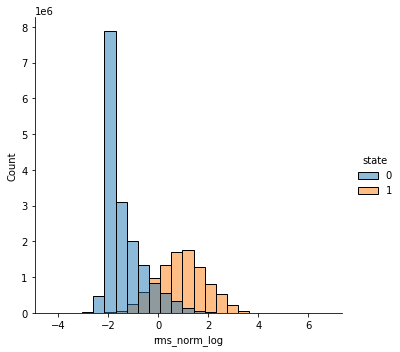

In [45]:
sns.displot(pump_data_replica, x="rms_norm_log", hue="state", bins=25)

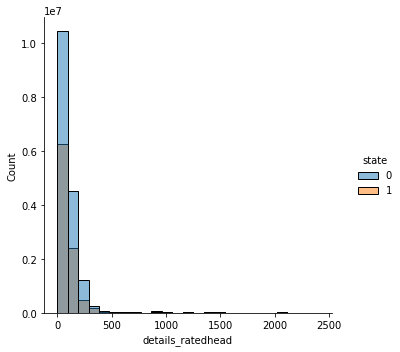

In [46]:
sns.displot(pump_data_replica, x="details_ratedhead", hue="state", bins=25)